## 기말고사 연습문제 1

### 패키지 선언

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader


### Dataset 선언

100%|██████████| 170M/170M [00:03<00:00, 43.5MB/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
50000
torch.Size([3, 32, 32])
9


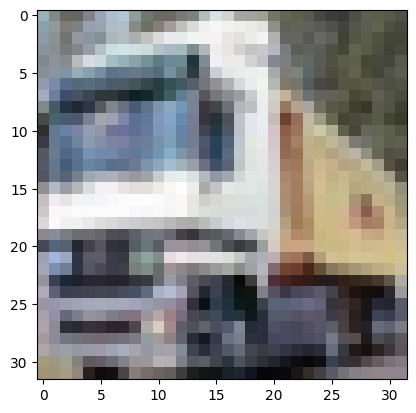

In [2]:
# Training dataset 다운로드
cifar10_train = dataset.CIFAR10(root = "./", # 데이터셋을 저장할 위치
                            train = True,
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar10_test = dataset.CIFAR10(root = "./",
                            train = False,
                            transform = transform.ToTensor(),
                            download = True)

from matplotlib import pyplot as plt
print(len(cifar10_train))     # training dataset 개수 확인

first_data = cifar10_train[1]
print(first_data[0].shape)  # 두번째 data의 형상 확인
print(first_data[1])        # 두번째 data의 정답 확인


plt.imshow(first_data[0].permute(1, 2, 0))
plt.show()

### CNN 모델 구현

In [42]:
class TestModel (nn.Module):
  def __init__ (self):
    super(TestModel, self).__init__()

    self.conv_11 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1,stride=1)
    #CNN [3x3x3]x16 필터 적용
    self.conv_12 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    #CNN [3x3x16]x32필터 적용
    self.conv1_skip = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1,stride=1)
    #Skip Connections용 필터 [3x3x3]x32 필터 적용


    self.conv_21 = nn.Conv2d(in_channels=35,out_channels=32,kernel_size=3,padding=1,stride=1)
    #[3x3x35]x32필터 적용
    self.conv_22 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1,stride=1)
    #[3x3x32]x64필터 적용
    self.adaptivePool = nn.AdaptiveAvgPool2d((1, 1))
    #GAP(각 채널의 평균을 가져옴) 적용

    #1x1 convolution
    # self.caconv1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1)
    # self.caconv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1)

    #fully connected layer
    self.flatten = nn.Flatten()
    self.caconv1 = nn.Linear(in_features=64, out_features=64)
    self.caconv2 = nn.Linear(in_features=64, out_features=64)
    self.sigmoid = nn.Sigmoid()
    #시그모이드 함수
    self.conv2_skip = nn.Conv2d(in_channels=35,out_channels=64,kernel_size=3,padding=1,stride=1)



    self.conv_31 = nn.Conv2d(in_channels=99,out_channels=128,kernel_size=3,padding=1,stride=1)
    #[3x3x99]x128필터 적용
    self.conv_32 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1,stride=1)
    #[3x3x128]x256필터 적용



    self.conv3_skip = nn.Conv2d(in_channels=99,out_channels=256,kernel_size=3,padding=1,stride=1)


    self.fc1 = nn.Linear(4096, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 10)

    self.relu = nn.ReLU()
    self.maxpooling = nn.MaxPool2d(2,2)


  def forward(self, x):

    input_feature = x
    out1 = self.relu(self.conv_11(x))
    out1 = self.relu(self.conv_12(out1))
    #CNN
    skip = self.relu(self.conv1_skip(input_feature))
    out1 = out1+skip
    #Skip Connection
    out1 = torch.cat([out1, input_feature], dim=1)
    #Dense Connection
    out1 = self.maxpooling(out1)

    input_feature = out1
    out2 = self.relu(self.conv_21(out1))
    out2 = self.relu(self.conv_22(out2))
    #CNN
    ca_out = self.adaptivePool(out2)
    ca_out = self.flatten(ca_out) #fully connected layer 평탄화
    ca_out = self.relu(self.caconv1(ca_out))
    ca_out = self.sigmoid(self.caconv2(ca_out))
    ca_out = ca_out.view(ca_out.size(0), 64, 1, 1) # fully connected layer 다시 3차원으로
    ca_out = ca_out.expand_as(out2)
    out2 = out2*ca_out
    #Channel attention
    skip = self.relu(self.conv2_skip(input_feature))
    out2 = out2+skip
    #Skip Connection
    out2 = torch.cat([out2, input_feature], dim=1)
    #Dense Connection
    out2 = self.maxpooling(out2)

    input_feature = out2
    out3 = self.relu(self.conv_31(out2))
    out3 = self.relu(self.conv_32(out3))
    #CNN
    out3 = out3+self.relu(self.conv3_skip(input_feature))
    #Skip Connection
    out3 = self.maxpooling(out3)


    # 평탄화
    out3 = out3.reshape(-1, 4096)
    # fully connected layers
    out3 = self.relu(self.fc1(out3))
    out3 = self.relu(self.fc2(out3))
    out3 = self.fc3(out3)

    return out3




### Hyper-parameters 지정 / Training / Test

In [43]:
# Hyper parameter
batch_size = 100
learning_rate = 0.1
training_epochs = 20
loss_function = nn.CrossEntropyLoss()
network = TestModel()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)
data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

# Training
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:0'

network = network.to(device)
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:

    img = img.to(device)
    label = label.to(device)

    pred = network(img)

    loss = loss_function(pred, label)
    optimizer.zero_grad() # gradient 초기화
    loss.backward()
    optimizer.step()

    avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f'%(epoch+1, avg_cost))

print('Learning finished')

#Test
network = network.to('cpu')
with torch.no_grad(): # test에서는 기울기 계산 제외

  img_test = torch.tensor(np.transpose(cifar10_test.data, (0, 3, 1, 2)))/255.
  label_test = torch.tensor(cifar10_test.targets)

  prediction = network(img_test) # 전체 test data를 한번에 계산

  correct_prediction = torch.argmax(prediction, 1) == label_test
  accuracy = correct_prediction.float().mean()
  print('Accuracy:', accuracy.item())

Epoch: 1 Loss = 2.098397
Epoch: 2 Loss = 1.613081
Epoch: 3 Loss = 1.333207
Epoch: 4 Loss = 1.111453
Epoch: 5 Loss = 0.927650
Epoch: 6 Loss = 0.781465
Epoch: 7 Loss = 0.659709
Epoch: 8 Loss = 0.543636
Epoch: 9 Loss = 0.430477
Epoch: 10 Loss = 0.334949
Epoch: 11 Loss = 0.238844
Epoch: 12 Loss = 0.170779
Epoch: 13 Loss = 0.117293
Epoch: 14 Loss = 0.094397
Epoch: 15 Loss = 0.065523
Epoch: 16 Loss = 0.050973
Epoch: 17 Loss = 0.048683
Epoch: 18 Loss = 0.048180
Epoch: 19 Loss = 0.035158
Epoch: 20 Loss = 0.031869
Learning finished
Accuracy: 0.7738999724388123


## -----------------------------------------------------------------

## 기말고사 연습문제 2

### 패키지 선언

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


### Dataset 선언

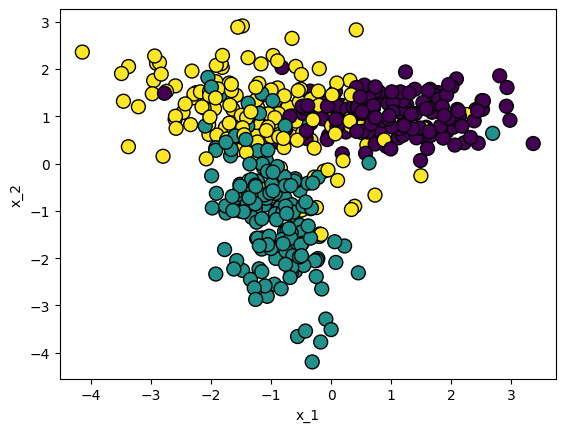

In [46]:
X, y = make_classification(n_samples=500,
                           n_features=2,
                           n_classes=3,
                           n_clusters_per_class=1,
                           n_informative=2,
                           n_redundant=0,
                           random_state=40)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100, edgecolor="k", linewidth=1)
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.show()

### SVM 모델 구현

In [50]:
class SVM:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None  # 가중치 벡터
        self.bias = None  # 절편

    def fit(self, X, y,find):
        """
        SVM 모델 학습
        - X: 입력 데이터 (data 개수 x feature 개수)
        - y: 타겟 레이블 (data 개수만큼 -1 또는 1로 이루어진 배열)
        """
        n_samples, n_features = X.shape # n_samples: 데이터 개수 ,  n_features 가중치 개수

        # 레이블을 -1 또는 1로 변환
        y_modified = np.where(y == find, -1, 1)
        # 레이블이 where조건에 맞으면 -1 아니면 1

        # Weight 및 bias 초기화
        self.weights = np.zeros(n_features)  # 가중치 벡터
        self.bias = 0  # 절편

        # Gradient Decent
        for _ in range(self.n_iters):
          for idx in range(n_samples):
            X_i = X[idx]
            y_i = y_modified[idx]

            condition = y_i * (np.dot(self.weights.T,X_i)+self.bias) >= +1
            #선택한 label ,
            if condition:
              pass
            else:
              #잘못 분류되었을때 가중치 조정
              self.weights = self.weights - self.learning_rate *(-np.dot(y_i,X_i))
              self.bias = self.bias - self.learning_rate *(-y_i)


    def predict(self, X):
        """
        새로운 데이터에 대한 클래스 예측
        - X: 입력 데이터
        - 반환값: 예측된 클래스 레이블 (-1 또는 1)
        """
        # 결정 함수: w^T * x + b
        linear_output = np.dot(X, self.weights) + self.bias
        # sign 함수로 -1 또는 1로 변환
        return np.sign(linear_output)

### Prediction

[-1  1  1  1  1  1  1  1  1 -1  1 -1 -1 -1  1  1 -1  1  1  1 -1 -1 -1  1
  1  1 -1  1 -1 -1 -1  1 -1  1  1 -1  1 -1  1  1  1  1  1  1  1  1 -1  1
  1  1  1 -1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1  1  1 -1  1  1
  1  1  1  1 -1  1  1  1 -1  1  1  1 -1  1  1 -1 -1 -1  1  1  1 -1  1  1
  1 -1  1  1  1  1  1 -1  1 -1 -1  1  1  1  1  1 -1  1 -1  1 -1  1 -1  1
  1  1  1  1  1  1 -1  1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1  1 -1 -1  1
  1 -1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1 -1  1  1  1
 -1  1  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1  1 -1  1  1 -1
 -1  1  1 -1  1  1  1  1 -1  1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1 -1
 -1 -1 -1  1 -1  1  1 -1  1  1  1  1  1  1 -1  1 -1  1  1  1  1  1  1 -1
 -1 -1 -1 -1  1  1 -1  1  1  1  1  1  1 -1 -1  1  1 -1  1 -1  1  1  1  1
 -1  1  1 -1  1 -1  1 -1 -1 -1 -1  1  1 -1  1 -1  1  1 -1  1 -1  1 -1  1
  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1 -1  1 -1  1 -1
  1  1  1 -1 -1  1  1  1 -1  1 -1  1  1 -1  1  1  1

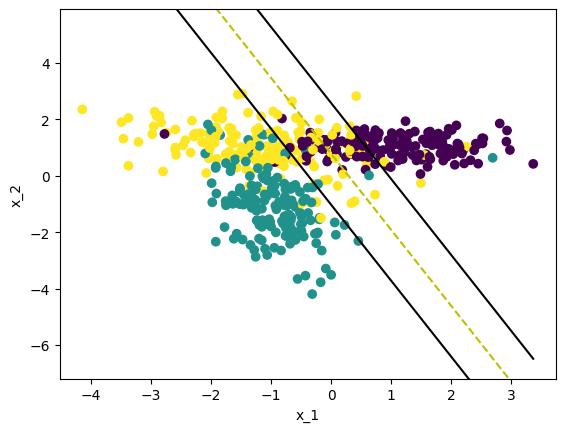

[ 1  1  1  1 -1 -1  1  1  1  1  1  1  1  1 -1 -1  1  1  1  1  1  1  1 -1
 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1 -1 -1 -1  1 -1  1  1 -1
 -1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1 -1  1
 -1  1  1 -1  1  1 -1 -1  1 -1  1 -1  1  1 -1  1  1  1  1 -1 -1  1  1  1
 -1  1  1  1 -1 -1  1  1  1  1  1 -1 -1  1  1  1  1  1  1 -1  1  1  1  1
 -1 -1 -1  1 -1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1 -1
 -1  1  1  1  1 -1  1 -1 -1  1  1 -1  1  1  1 -1 -1  1  1 -1  1  1 -1 -1
  1  1  1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1  1  1 -1  1  1 -1  1
  1  1 -1  1 -1  1  1  1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1
  1  1  1  1  1  1 -1  1 -1  1  1  1 -1  1  1  1  1 -1  1 -1 -1 -1  1  1
  1  1  1  1  1 -1  1  1  1 -1  1 -1  1  1  1 -1 -1  1 -1  1  1 -1 -1 -1
  1 -1  1  1  1  1 -1  1  1  1  1 -1 -1  1 -1  1 -1  1  1  1  1 -1  1 -1
  1 -1 -1  1 -1  1 -1  1 -1  1  1 -1 -1  1 -1 -1  1  1  1  1  1  1  1  1
 -1 -1  1  1  1  1  1 -1  1 -1  1 -1  1  1 -1 -1  1

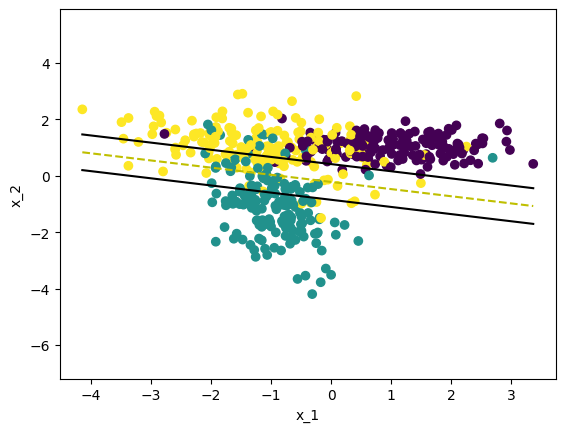

[ 1 -1 -1 -1  1  1 -1 -1 -1  1 -1  1  1  1  1  1  1 -1 -1 -1  1  1  1  1
  1 -1  1 -1  1  1  1 -1  1 -1  1  1 -1  1  1 -1  1  1  1 -1  1 -1  1  1
  1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1
  1 -1 -1  1  1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1 -1  1  1  1 -1 -1
  1  1 -1 -1  1  1 -1  1 -1  1  1  1  1 -1 -1 -1  1 -1  1  1  1 -1  1 -1
  1  1  1 -1  1 -1  1 -1  1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1  1  1
  1  1 -1  1 -1  1 -1  1  1 -1 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1  1
  1 -1 -1  1  1 -1  1 -1 -1  1 -1  1 -1  1 -1 -1  1  1  1  1  1 -1  1  1
  1 -1  1  1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1 -1 -1  1 -1  1  1
  1  1  1 -1  1 -1  1  1  1 -1 -1 -1  1 -1  1 -1  1  1 -1  1  1  1 -1  1
  1  1  1  1 -1  1  1 -1 -1  1 -1  1 -1  1  1  1  1  1  1  1 -1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1 -1  1  1  1  1
 -1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1  1
  1  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1 -1

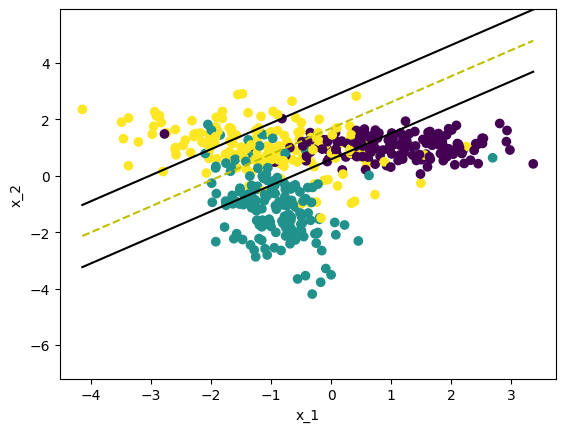

In [51]:
# model 1
def get_hyperplane_value(x, w, b, offset):
    return (-w[0] * x - b + offset) / w[1]

def visualize_svm(w, b):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.scatter(X[:, 0], X[:, 1], marker="o", c=y)

    x0_1 = np.amin(X[:, 0])
    x0_2 = np.amax(X[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])
    plt.xlabel("x_1")
    plt.ylabel("x_2")
    plt.show()



model = SVM()
margin_log = model.fit(X, y,0)
#label이 0일때 학습
print(model.weights, model.bias)
visualize_svm(model.weights, model.bias)



# model 2
model = SVM()
margin_log = model.fit(X, y,1)
#label이 1일때 학습
print(model.weights, model.bias)
visualize_svm(model.weights, model.bias)


# model 3
model = SVM()
margin_log = model.fit(X, y,2)
#label이 2일때 학습
print(model.weights, model.bias)
visualize_svm(model.weights, model.bias)







## -----------------------------------------------------------------

## 기말고사 연습문제 3

### 패키지 선언

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Dataset 선언

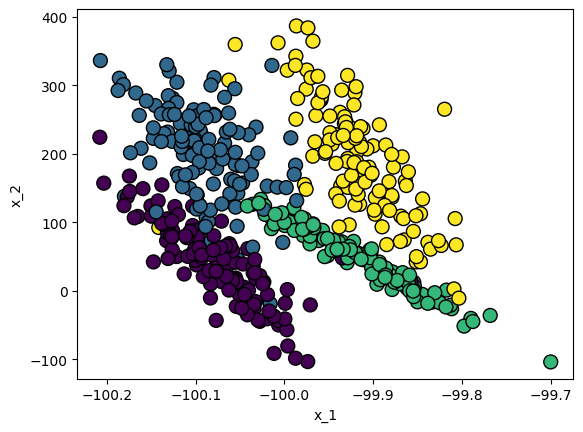

Training samples:  400
Testing samples:  100


In [ ]:
X, y = make_classification(n_samples=500,
                           n_features=2,
                           n_classes=4,
                           n_clusters_per_class=1,
                           n_informative=2,
                           n_redundant=0,
                           random_state=40)

scaler = StandardScaler()
X= scaler.fit_transform(X)

X[:, 0] = X[:, 0] * 0.1 - 100
X[:, 1] = X[:, 1] * 100 + 120

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100, edgecolor="k", linewidth=1)
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.show()

# Training/Testing Dataset 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)


print("Training samples: ", len(X_train))
print("Testing samples: ", len(X_test))

### 정규화 수행

In [ ]:
scaler = StandardScaler()
X= scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

### KNN 모델 구현

In [ ]:
def L2_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
  def __init__(self, k=3):
    self.k=k
    self.data = None
    self.label = None
    # initialization

  def fit(self, X, y):
    self.data=X
    self.lable=y
    # Storage training datas

  def predict(self, X):
    answer = []
    for input in X:
      dist = []
      for input2 in self.data:
        dist.append(L2_distance(input,input2))
      #각 거리를 구하고
      argSort =np.argsort(dist)[:self.k]
      #이미 확정된 데이터 중 점과의 거리가 짧은거 k개를 골라
      label = []
      for i in argSort:
        label.append(self.lable[i])
      #고른것들의 label을 가져옴
      answer.append(max(label,key = label.count))#label 중 가장 많은걸 가져옴
      #answer.append(min(label,key = label.count))#가장 적은걸 가져옴

      #평균 , 중간값 추가
    return answer


### Prediction

In [ ]:
model = KNN()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = np.sum(y_pred == y_test) / len(y_test)
print(accuracy)

0.94


## -----------------------------------------------------------------

## 기말고사 연습문제 4

### 패키지 선언

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

### Dataset 선언

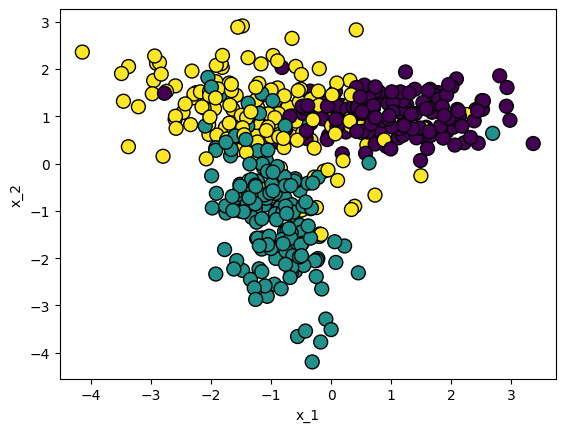

Training samples:  400
Testing samples:  100


In [54]:
X, y = make_classification(n_samples=500,
                           n_features=2,
                           n_classes=3,
                           n_clusters_per_class=1,
                           n_informative=2,
                           n_redundant=0,
                           random_state=40)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=100, edgecolor="k", linewidth=1)
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.show()

# Training/Testing Dataset 분리 (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

print("Training samples: ", len(X_train))
print("Testing samples: ", len(X_test))

### Training dataset 분리

In [55]:
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)

### KNN 모델 구현

In [56]:
def L2_distance(x1, x2):
  return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
  def __init__(self, k=3):
    # initialization
    self.k = k
    self.data = None
    self.label = None
  def fit(self, X, y):
    self.data = X
    self.label = y
    # Storage training datas

  def predict(self, X,k):
    self.k = k
    # Prediction
    answer = []
    for i in X:
      dist = []
      for j in self.data:
        dist.append(L2_distance(i,j))
      argSort = np.argsort(dist)[:self.k]
      label = []
      for i in argSort:
        label.append(self.label[i])
      answer.append(max(label,key = label.count))
    return answer

### Prediction

In [57]:
model = KNN()
model.fit(X_train_temp, y_train_temp)
k_list = list(range(1, 10))

arr = []
for k in k_list:
  y_pred = model.predict(X_test_temp, k)
  #print(y_pred)
  accuracy = np.sum(y_pred == y_test_temp) / len(y_test_temp)
  arr.append(accuracy)
print("answer : " + str(np.argmax(arr) + 1))

answer : 5
